In [1]:
from matplotlib import pyplot as plt
from pyppca import ppca
from sklearn import mixture
from sklearn.cluster import SpectralClustering
from operator import itemgetter
import os
from sklearn.decomposition import PCA
import numpy as np
import pickle
import sys
import pandas as pd
import scanpy as sc
from sklearn.metrics import *
data_folder_path = '../../../data'
sys.path.append(data_folder_path)
import matplotlib.patches as mpatches
import anndata as ad
from sklearn.neighbors import NearestNeighbors
import tensorflow as tf
import gpflow
float_type = gpflow.default_float()
import gpflux
from gpflow.config import default_float
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import muon as mu
from muon import atac as ac
from muon import prot as pt
sys.path.append('../../../mogp_decomposition/')
import mwgp as mwgp
from mwgp import GPD
import glob
from GRM import *
import seaborn as sns

def get_free_gpu_idx():
    """Get the index of the GPU with current lowest memory usage."""
    os.system("nvidia-smi -q -d Memory |grep -A4 GPU|grep Used >tmp")
    memory_available = [int(x.split()[2]) for x in open("tmp", "r").readlines()]
    return np.argmin(memory_available)

gpu_idx = get_free_gpu_idx()
print("Using GPU #%s" % gpu_idx)
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_idx)

2024-06-03 19:57:54.137958: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-03 19:57:54.345759: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-03 19:57:54.399165: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-03 19:57:56.524268: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

Using GPU #2
Using GPU #2


## 1. Preparing Dataset PBMC

## 2. Loading Dataset PBMC: ENV MOGP-TF-Florian 

In [2]:
file_path = os.path.join(data_folder_path, 'CITEseq', 'pbmc5k_citeseq.h5mu')
mdata = mu.read(file_path)
mu.pp.intersect_obs(mdata)
rna = mdata.mod['rna']
rna = rna[:,rna.var.highly_variable]
prot = mdata.mod['prot']

col_dict1 = {'CD14 mono': '#8000ff',
                 'memory-like NK': '#5641fd',
                 'CD8+ naïve T': '#2c7ef7',
                 'pDC': '#00b5eb',
                 'CD16 mono': '#2adddd',
                 'intermediate mono': '#54f6cb',
                 'CD4+ naïve T': '#80ffb4',
                 'mature B': '#abf69b',
                 'CD4+ memory T': '#d4dd80',
                 'NK': '#ffb360',
                 'CD8+ memory T': '#ff7e41',
                 'pre-B': '#ff4121',
                 'Treg': '#ff0000',
                 None: '#CDC9C9'}

In [3]:
rna

View of AnnData object with n_obs × n_vars = 3891 × 1734
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'celltype'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [4]:
prot

AnnData object with n_obs × n_vars = 3891 × 32
    obs: 'celltype'
    var: 'gene_ids', 'feature_types', 'highly_variable'
    uns: 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [5]:
RNA_Normalized_2000 = (rna.X-np.mean(rna.X,0))/np.std(rna.X,0)

prot_Normalized_2000 = (prot.X-np.mean(prot.X,0))/np.std(prot.X,0)

## 3. Defining the model: ENV MOGP-TF-Florian 

## 4. Evaluation: ENV MOGP-TF-Florian 

## 5. Running SEACells: ENV SEACells

## 6. PROT Relevance Map: ENV MOGP-TF-Florian 

In [23]:
dim1 = 2
dim2 = 2
dim3 = 2
num_epochs = 500
n_inducing_points1 = 512
n_inducing_points2 = 512
batch_size = 100000
with_PCA = 0
with_PPCA = 0
scale_emb1 = 0
scale_emb2 = 0
emb_reg = 0.001

In [24]:
title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+' with_PCA='+str(with_PCA)
save_path = './PBMC5KCITEseqMultiView-GPFlux  '+title+'/seaCell_cells.csv' 
file = open(save_path,'rb')
object_file = pickle.load(file)
file.close()

RNA_struct_MOGP = ad.AnnData(object_file)
RNA_struct_MOGP.obsm['X_umap']= object_file

In [25]:
title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+' with_PCA='+str(with_PCA)
save_path = './PBMC5KCITEseqMultiView-GPFlux  '+title+'/seaCell_genes.csv' 
file = open(save_path,'rb')
object_file = pickle.load(file)
file.close()

Genes_struct_MOGP = ad.AnnData(object_file)
Genes_struct_MOGP.obsm['X_umap']= object_file

In [26]:
n_SEACells_cells=60
title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+' with_PCA='+str(with_PCA)
save_path = './PBMC5KCITEseqMultiView-GPFlux  '+title+'/'+'NumMetaCells='+str(n_SEACells_cells)+'seaCell_metaCells.csv' 
file = open(save_path,'rb')
metaCells = pickle.load(file)
file.close()
RNA_struct_MOGP.obs[['SEACell']]=metaCells
n_SEACells_genes=120
title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+' with_PCA='+str(with_PCA)
save_path = './PBMC5KCITEseqMultiView-GPFlux  '+title+'/'+'NumMetaCells='+str(n_SEACells_genes)+'seaCell_metaGenes.csv' 
file = open(save_path,'rb')
metaGenes = pickle.load(file)
file.close()
Genes_struct_MOGP.obs[['SEACell']]=metaGenes

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


<AxesSubplot: xlabel='0', ylabel='1'>

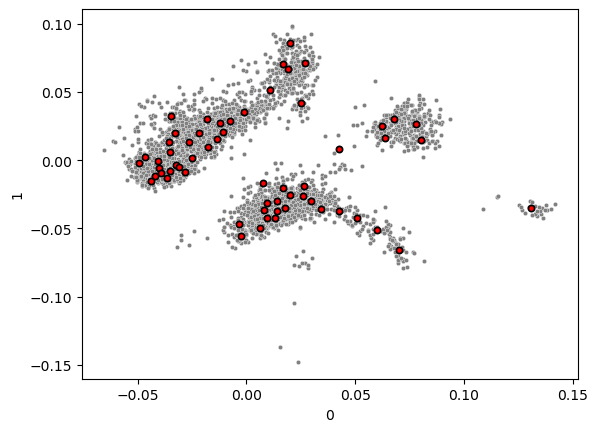

In [27]:
umap = pd.DataFrame(RNA_struct_MOGP.obsm['X_umap']).set_index(RNA_struct_MOGP.obs_names).join(RNA_struct_MOGP.obs['SEACell'])
umap['SEACell'] = umap['SEACell'].astype("category")
mcs_cells = umap.groupby('SEACell').mean().reset_index()
sns.scatterplot(x=0, y=1,
                        color='grey',
                        data=umap,
                        s=10,
                        cmap='Set2',
                        legend=None)
sns.scatterplot(x=0, y=1, s=20,
                color='red',
                data=mcs_cells,
                cmap='Set2',
                edgecolor='black', linewidth=1.25,
                legend=None)

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


<AxesSubplot: xlabel='0', ylabel='1'>

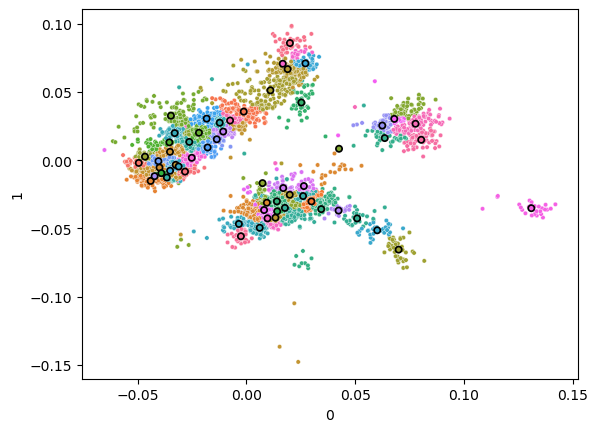

In [28]:
sns.scatterplot(x=0, y=1,
                        hue='SEACell',
                        data=umap,
                        s=10,
                        cmap='Set2',
                        legend=None)
sns.scatterplot(x=0, y=1, s=20,
                hue='SEACell',
                data=mcs_cells,
                cmap='Set2',
                edgecolor='black', linewidth=1.25,
                legend=None)

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


<AxesSubplot: xlabel='0', ylabel='1'>

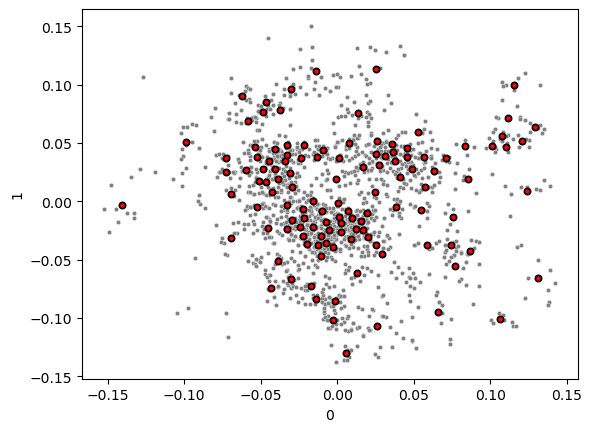

In [29]:
import seaborn as sns
umap = pd.DataFrame(Genes_struct_MOGP.obsm['X_umap']).set_index(Genes_struct_MOGP.obs_names).join(Genes_struct_MOGP.obs['SEACell'])
umap['SEACell'] = umap['SEACell'].astype("category")
mcs_genes = umap.groupby('SEACell').mean().reset_index()
sns.scatterplot(x=0, y=1,
                        color='grey',
                        data=umap,
                        s=10,
                        cmap='Set2',
                        legend=None)
sns.scatterplot(x=0, y=1, s=20,
                color='red',
                data=mcs_genes,
                cmap='Set2',
                edgecolor='black', linewidth=1.25,
                legend=None)





/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


<AxesSubplot: xlabel='0', ylabel='1'>

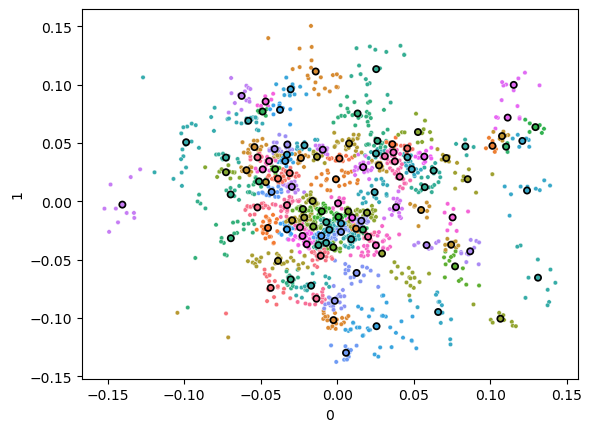

In [30]:
sns.scatterplot(x=0, y=1,
                        hue='SEACell',
                        data=umap,
                        s=10,
                        cmap='Set2',
                        legend=None)
sns.scatterplot(x=0, y=1, s=20,
                hue='SEACell',
                data=mcs_genes,
                cmap='Set2',
                edgecolor='black', linewidth=1.25,
                legend=None)

In [31]:
RNA_struct_MOGP

AnnData object with n_obs × n_vars = 3891 × 2
    obs: 'SEACell'
    obsm: 'X_umap'

In [32]:
Genes_struct_MOGP

AnnData object with n_obs × n_vars = 1734 × 2
    obs: 'SEACell'
    obsm: 'X_umap'

### Standard method

In [33]:
n_neighbors=6
rg_max=10
n_bins=200

In [34]:
rank_dhatpc = rank_dhatpc_score(RNA_struct_MOGP, prot_Normalized_2000, n_neighbors)

In [35]:
#title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+' with_PCA='+str(with_PCA)
#save_path = './PBMC5KCITEseqMultiView-GPFlux  '+title+'/'+'rank_dhatgc_ProtRelevance3.csv' 
#file = open(save_path,'wb')
#pickle.dump(rank_dhatpc,file)
#file.close()

In [36]:
title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+' with_PCA='+str(with_PCA)
save_path = './PBMC5KCITEseqMultiView-GPFlux  '+title+'/'+'rank_dhatgc_ProtRelevance3.csv' 
file = open(save_path,'rb')
rank_dhatpc = pickle.load(file)
file.close()

#### prot relevance

In [37]:
LR_pPsi, avg_Psi = LRpPsi_avgPsi_score(RNA_struct_MOGP, prot_Normalized_2000, rank_dhatpc, rg_max)

In [38]:
###NK, mem NK
####CD16_TotalSeqB #CD56_TotalSeqB TIGIT_TotalSeqB CD335_TotalSeqB
###
###4memory 4naive 8naive 8memory
####CD127_TotalSeqB #CD28_TotalSeqB #CD27_TotalSeqB
###
###matureB pre-B
####CD19_TotalSeqB #CD20_TotalSeqB #HLA-DR_TotalSeqB
###
###intermediate mono 16 14
####CD14_TotalSeqB #CD86_TotalSeqB #HLA-DR_TotalSeqB
###
###
###4memory 4naive 8naive 8memory
####CD127_TotalSeqB
###
###4memory 4naive 8naive 8memory treg
####CD28_TotalSeqB 
###
###4memory 8memory treg intermediate 16
####CD45RO_TotalSeqB
###
###4memory 4naive 8naive 8memory treg mature
####CD27_TotalSeqB
###
###matureB pre-B
####CD19_TotalSeqB #CD20_TotalSeqB 
###
###intermediate mono 16 14
####CD14_TotalSeqB #CD86_TotalSeqB 
###
###intermediate mono 16 14 matureB pre-B
####HLA-DR_TotalSeqB
prot_list=['CD16_TotalSeqB','CD56_TotalSeqB','TIGIT_TotalSeqB',
           'CD127_TotalSeqB','CD28_TotalSeqB','CD27_TotalSeqB',
           'CD14_TotalSeqB','CD86_TotalSeqB','HLA-DR_TotalSeqB',
           'CD19_TotalSeqB','CD20_TotalSeqB', 'HLA-DR_TotalSeqB',]

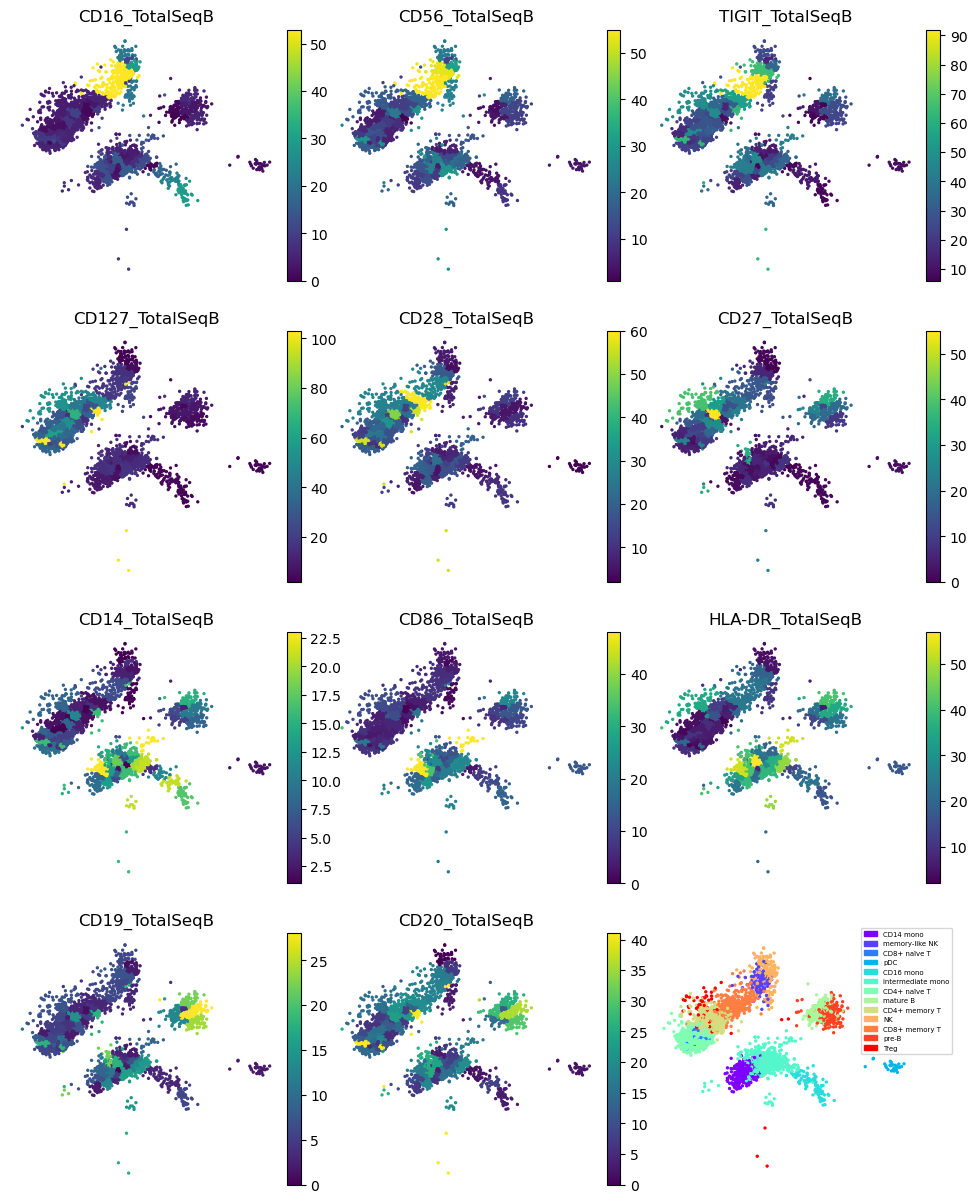

In [39]:
Prot_Relevance_Map(rna, prot, RNA_struct_MOGP, prot_list, LR_pPsi, avg_Psi, col_dict1, n_cell_types=13)